## Data Loading

Melakukan import library yang dibutuhkan dan memuat dataset yang akan digunakan.

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import LancasterStemmer
import seaborn as sns
import nltk
import string
import re
import seaborn as sns
from sklearn.utils import resample
from nltk.corpus import stopwords
from langdetect import detect # type: ignore
import contextualSpellCheck

c:\Users\Gede Darmawan\OneDrive\Documents\project\Aspect-Based-Sentiment-Analysis-Hotel-Review\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Melakukan download Toolkit yang dibutuhkan untuk melakukan preprocessing data.
- `stopwords` : Toolkit yang berisi kumpulan kata-kata yang tidak memiliki makna dan biasanya dihilangkan pada proses preprocessing data.
- `wordnet` : Toolkit yang berisi kumpulan kata-kata digunakan untuk melakukan stemming pada proses preprocessing data.
- `omw` : Toolkit yang berisi kumpulan kata-kata yang digunakan untuk melakukan lemmatization pada proses preprocessing data.

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\Gede
[nltk_data]     Darmawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Gede
[nltk_data]     Darmawan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Gede
[nltk_data]     Darmawan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Melakukan loading dataset yang akan digunakan dan memilih kolom yang akan digunakan yaitu `ratings_overall`, `title`, dan `text`.

In [3]:
df_data = pd.read_csv('Data/data_2/review.csv')
df_data = df_data[['ratings_overall', 'title', 'text']]
df_data

,ratings_overall,title,text
0,5.0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...
1,5.0,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the..."
2,4.0,“Great Stay”,This is a great property in Midtown. We two di...
3,4.0,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...
4,4.0,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...
...,...,...,...
878556,4.0,“vil komme igen”,"Pænt hotel i et livligt miljø. Store værelser,..."
878557,4.0,“excellent”,"un excellent hotel 4 *, pour un prix raisonnab..."
878558,5.0,“Un hotel eccezionale”,"L'hotel, situato in una zona tranquilla e a du..."
878559,5.0,“Gerne wieder”,Sehr schön ausgestattetes Hotel in bester Lage...


Dari output code di atas, terlihat terdapat 3 kolom dan 878561 baris dataset yang akan digunakan.

## Exploratory Data Analysis

Tahap selanjutnya adalah melakukan Exploratory Data Analysis (EDA) untuk mengetahui karakteristik dari dataset yang akan digunakan, seperti:
- Tipe data
- Statistik deskriptif
- Distribusi data
- Missing value
- Duplikasi data

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878561 entries, 0 to 878560
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ratings_overall  878561 non-null  float64
 1   title            878561 non-null  object 
 2   text             878561 non-null  object 
dtypes: float64(1), object(2)
memory usage: 20.1+ MB


Dari output code di atas, terlihat bahwa dataset yang akan digunakan memiliki tipe data `object` pada kolom `title` dan `text`, serta tipe data `float64` pada kolom `ratings_overall`.

In [5]:
print('duplicated\t', df_data.duplicated().sum())
print(df_data.isnull().sum())

duplicated	 803
ratings_overall    0
title              0
text               0
dtype: int64


Dari output code di atas, terlihat terdapat 803 duplikasi data pada dataset yang akan digunakan. Sedangkan tidak terdapat missing value pada dataset yang akan digunakan.

In [6]:
df_data.describe()

,ratings_overall
count,878561.000000
mean,3.936228
std,1.165074
min,0.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


Dari deskripsi statistik tersebut, terlihat bahwa rata-rata rating yang diberikan oleh user adalah 3.9 dengan standar deviasi sebesar 1.3. Sedangkan nilai median dari rating yang diberikan oleh user adalah 4.0. Hal ini menunjukan bahwa data cenderung memiliki left skewness.

Langkah selanjutnya adalah melakukan encoding pada kolom `ratings_overall` menjadi 3 kelas yaitu `negative`, `neutral`, dan `positive` berdasarkan nilai rating yang diberikan oleh user.

In [7]:
encoding = {
    1: 'negative',
    2: 'negative',
    3: 'neutral',
    4: 'positive',
    5: 'positive'
}

In [8]:
df_data['label'] = df_data['ratings_overall'].map(encoding)

<Axes: xlabel='label'>

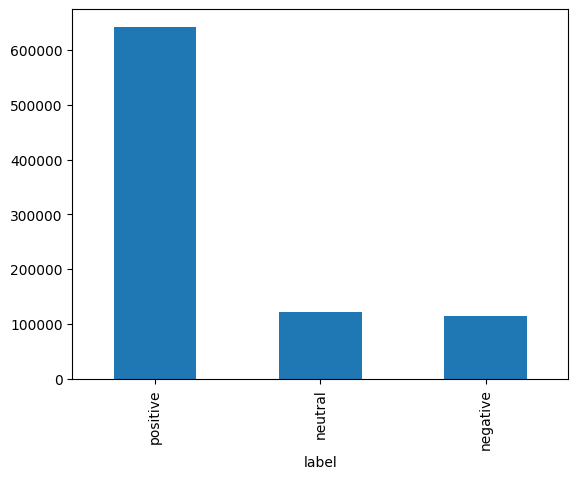

In [9]:
df_data['label'].value_counts().plot(kind='bar')

In [10]:
df_data['label'].value_counts()

label
positive    642046
neutral     122565
negative    113933
Name: count, dtype: int64

Dari diagram batang dan value count di atas, terlihat bahwa data cenderung tidak seimbang, dimana terdapat lebih banyak data yang memiliki rating `positive` dibandingkan dengan data yang memiliki rating `negative` dan `neutral`.

## Data Preprocessing

Langkah selanjutnya adalah melakukan preprocessing data pada kolom `text` yang akan digunakan sebagai fitur pada model yang akan dibuat.

### Remove Duplicate Data

In [11]:
df_data.drop_duplicates(inplace=True)
df_data.duplicated().sum()

0

### Downsample Data

Skewness data dapat diatasi dengan menggunakan teknik upsampling atau downsampling, tetapi pada studi kasus ini karena data yang digunakan cukup besar, maka akan dilakukan downsampling saja. Selain untuk mengatasi data yang tidak seimbang, downsampling ini juga bertujuan untuk mempercepat proses komputasi.

In [12]:
df_new = pd.DataFrame()
target_count = 53834

for rating, group in df_data.groupby('label'):
    if len(group) > target_count:
        ratings_new = resample(group, replace=False, n_samples=target_count, random_state=42)
    else:
        ratings_new = group
    df_new = pd.concat([df_new, ratings_new])

df_data = df_new.reset_index(drop=True)
df_data['label'].value_counts()

label
negative    53834
neutral     53834
positive    53834
Name: count, dtype: int64

Dari output code di atas, terlihat bahwa data yang digunakan setelah dilakukan yaitu masing-masing berjumlah 53834 data per label.

Selanjutnya kolom `title` dan `text` akan digabungkan menjadi satu kolom baru yaitu `text` yang akan digunakan sebagai fitur pada model yang akan dibuat.

In [13]:
df_data['text'] = df_data['title'] + ' ' + df_data['text']
df_data = df_data[['ratings_overall', 'text', 'label']]

### Remove Non-English Text

Langkah selanjutnya adalah melakukan penghapusan data yang bukan berbahasa Inggris. Hal ini dilakukan untuk memastikan bahwa data yang digunakan dalam model adalah data yang berbahasa Inggris, hal ini bertujuan agar preprocessing data yang dilakukan secara seragam.

In [14]:
def language_detection(text):
    try:
        return detect(text)
    except:
        return 'other'

In [15]:
df_data['language'] = df_data['text'].apply(language_detection)
df_data.value_counts('language')

language
en       141742
de         4776
fr         4366
it         4038
es         2866
ja         1127
pt          802
sv          539
nl          481
da          331
no          224
zh-cn        93
ru           53
tr           28
pl           11
ko            7
af            4
el            4
th            3
ca            2
zh-tw         2
so            1
tl            1
id            1
Name: count, dtype: int64

Dari output code di atas, terlihat bahwa data yang berbahasa Inggris berjumlah 141739 yang dilabelkan dengan `en`, sehingga hanya data yang memiliki label `en` yang akan digunakan.

In [16]:
df_data = df_data[df_data['language'] == 'en']

### Remove Special Character and Additional Cleaning

Pada tahap ini akan dilakukan penghapusan karakter khusus atau simbol yang tidak diperlukan pada teks.

In [17]:
def remove_punctuation(text):
    text = ''.join([char if char not in string.punctuation else ' ' for char in text]).lower()
    return text

Selain itu akan dilakukan replace beberapa kata yang sering digunakan dalam bahasa Inggris dan juga menghapus karakter non-ASCII.

In [18]:
def additional_cleaning(text):
    replacements = {
        'n t': 'not',
        'nt': 'not',
        'didn t': 'did not',
        'didn': 'did not',
        'don t': 'do not',
        'don': 'do not',
        'doesn t': 'does not',
        'doesn': 'does not',
        'hasn t': 'has not',
        'hasn': 'has not',
        'haven t': 'have not',
        'haven': 'have not',
        'hadn t': 'had not',
        'hadn': 'had not',
        'won t': 'will not',
        'won': 'will not',
        'wouldn t': 'would not',
        'wouldn': 'would not',
        'can t': 'can not',
        'can': 'can not',
        'couldn t': 'could not',
        'couldn': 'could not',
        'shouldn t': 'should not',
        'shouldn': 'should not',
        'aren t': 'are not',
        'aren': 'are not',
        'ain t': 'am not',
        'ain': 'am not',
        'isn t': 'is not',
        'isn': 'is not',
        'wasn t': 'was not',
        'wasn': 'was not',
        'were t': 'were not',
        'were': 'were not',
        'weren t': 'were not',
        'weren': 'were not',
        'what s': 'what is',
        'what': 'what is',
        'who s': 'who is',
        'who': 'who is',
        'where s': 'where is',
        'where': 'where is',
        'when s': 'when is',
        'when': 'when is',
        'why s': 'why is',
        'why': 'why is',
        'how s': 'how is',
        'how': 'how is',
        'll': 'will',
        've': 'have',
        're': 'are',
        'm': 'am',
        'em': 'them',
        'thats': 'that is',
        'that s': 'that is'
    }
    for old, new in replacements.items():
        text = re.sub(r'\b' + old + r'\b', new, text)

    text = re.sub(r'[^\x00-\x7F]+', '', text)

    return text

In [19]:
df_data['clean_punc'] = df_data['text'].apply(lambda x: remove_punctuation(x)).apply(lambda x: additional_cleaning(x))

### Stopwords Removal


Langkah selanjutnya adalah melakukan penghapusan stopwords pada teks dengan menggunakan toolkit `stopwords` berbahasa Inggris.

In [20]:
stopwords_list = stopwords.words('english')
def remove_stopwords(text):
    token_words = text.split()
    filtered_words = []
    for word in token_words:
        if word not in stopwords_list:
            filtered_words.append(word)
    return ' '.join(filtered_words)

In [21]:
df_data['clean_punc'] = df_data['clean_punc'].apply(lambda x: remove_stopwords(x))

### Lemmatization

Sebelum itu akan dilakukan pemanggilan pre-trained model dari spaCy untuk melakukan proses lemmatization.

In [22]:
nlp = spacy.load('en_core_web_lg')

Pada lemmatization akan dilakukan dengan menggunakan pre-trained model dari spaCy, dimana proses lemmatization ini akan mengubah kata-kata yang ada pada teks menjadi kata dasar dari kata-kata tersebut.

In [23]:
def lemmatize_text(texts):
    lemmatized_texts = []
    for doc in nlp.pipe(texts, n_process=6,batch_size=1000):
        lemmatized_text = ' '.join([token.lemma_ for token in doc])
        lemmatized_texts.append(lemmatized_text)
    return lemmatized_texts

In [24]:
df_data['lemmatized_review'] = lemmatize_text(df_data['clean_punc'])

### Remove Word-Number Combination

Selanjutnya akan dilakukan penghapusan kata-kata yang merupakan kombinasi antara kata dan angka, hal ini bertujuan untuk mengurangi hal-hal yang tidak diperlukan pada teks.

In [25]:
def remove_token_with_word_and_number(text):
    words = text.split()
    filtered_words = []
    for word in words:
        if not any(char.isdigit() for char in word):
            filtered_words.append(word)
    return ' '.join(filtered_words)


In [26]:
df_data['number_review'] = df_data['lemmatized_review'].apply(lambda x: remove_token_with_word_and_number(x))

### Named Entity Recognition

Langkah selanjutnya adalah melakukan proses Named Entity Recognition (NER) pada teks. NER adalah proses untuk mengidentifikasi entitas yang memiliki makna tertentu pada teks, seperti nama orang, nama tempat, dan lain sebagainya. Hal ini bertujuan agar nama-nama entitas tersebut tidak suatu hal yang penting pada proses klasifikasi sentimen.

Pada NER ini pre-trained model yang sebelumnya digunakan untuk lemmatization akan digunakan kembali.

In [39]:
def perform_ner(texts,mode):
    replaced_texts = []
    if mode == 'ner': 
        for doc in nlp.pipe(texts, n_process=6, batch_size=1000):
            replaced_text = []
            for token in doc:
                if token.ent_type_:
                    replaced_text.append(token.ent_type_)
                else:
                    replaced_text.append(token.text)
            replaced_texts.append(' '.join(replaced_text))
    else:
        for doc in nlp.pipe(texts, n_process=6, batch_size=1000):
            replaced_text = []
            for token in doc:
                if not token.ent_type_:
                    replaced_text.append(token.text)
            replaced_texts.append(' '.join(replaced_text))
    
    return replaced_texts

In [40]:
df_data['ner_review'] = perform_ner(df_data['number_review'],'ner')
df_data['rner_review'] = perform_ner(df_data['number_review'],'rner')

In [41]:
print('Original Review:\t', df_data['text'][0])
print('Lemmatized Review:\t', df_data['lemmatized_review'][0])
print('Token Number Review:\t', df_data['number_review'][0])
print('Name Entity R Review:\t', df_data['ner_review'][0])
print('Remove Name ER Review:\t', df_data['rner_review'][0])

Original Review:	 “Near Airport with Good Shuttle Service” Stayed here for a night on the way back from Hawaii on a very short layover with my family of five. Arrived around 9 and the shuttle service was the best part about the stay. Very convenient, friendly driver and quick ride from airport. Check-in took a while since everyone getting off the shuttle checks in at once.
We reserved a "family room" that had a room with two double beds and a connecting room with a king bed, but only one bathroom. Room was a great size but this is an older property and our room was at the very end of a series of hallways and confusing walkways and elevators to reach; I'm guessing one of the older rooms. It had a stale smell and was in need of renovation both in the rooms and bathroom. Bed comforters looked old and dirty. 
Went down to the restaurant to eat, since we hadn't eaten dinner and kids were starving. Even though we arrived toward the end of their posted hours you could tell they didn't want to

In [42]:
df_data.head()

,ratings_overall,text,label,language,clean_punc,lemmatized_review,number_review,ner_review,rner_review
0,2.0,“Near Airport with Good Shuttle Service” Staye...,negative,en,near airport good shuttle service stayed night...,near airport good shuttle service stay night w...,near airport good shuttle service stay night w...,near airport good shuttle service stay night w...,near airport good shuttle service stay night w...
1,1.0,“Gets a low ranking for a reason...” I've few ...,negative,en,gets low ranking reason positive things say ho...,get low rank reason positive thing say hotel s...,get low rank reason positive thing say hotel s...,get low rank reason positive thing say hotel s...,get low rank reason positive thing say hotel s...
2,2.0,“Budget hotel pretending to be a resort” The H...,negative,en,budget hotel pretending resort hanalei hotel r...,budget hotel pretend resort hanalei hotel real...,budget hotel pretend resort hanalei hotel real...,budget hotel pretend resort ORG ORG really mot...,budget hotel pretend resort really motel level...
3,1.0,“Dish out a few extra bucks and stay elsewhere...,negative,en,dish extra bucks stay elsewhere place looks ac...,dish extra buck stay elsewhere place look acce...,dish extra buck stay elsewhere place look acce...,dish extra buck stay elsewhere place look acce...,dish extra buck stay elsewhere place look acce...
4,2.0,“L.A. on a budget” The Good: Lowest cost for a...,negative,en,l budget good lowest cost branded hotel near d...,l budget good low cost brand hotel near downto...,l budget good low cost brand hotel near downto...,l budget good low cost brand hotel near downto...,l budget good low cost brand hotel near downto...


In [43]:
df_clean = df_data[['ner_review', 'ratings_overall', 'label']]
df_clean.columns = ['text', 'rating', 'label']

In [44]:
df_clean.to_csv('Data/data_2/clean_review_160k.csv', index=False)